In [1]:
import os
os.chdir("../../scVI/")
os.getcwd()

'/data/yosef2/users/chenling/scVI'

In [2]:
import torch
import pickle
import seaborn as sns
import numpy as np
import pandas as pd
from umap import UMAP
from sklearn.cluster import SpectralClustering
from scvi.inference import UnsupervisedTrainer
from scvi.models import VAE
save_path = '../CSF/Notebooks/'

import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
%matplotlib inline

In [3]:
from random import sample
from numpy.random import permutation


In [4]:
%matplotlib inline

In [5]:
celllabels = np.load(save_path + 'meta/celllabels.npy')
isCD4 = celllabels=='CD4'

In [6]:
clusters = np.load(save_path + 'meta/CD4.clusters.npy')

In [7]:
isMS = np.load(save_path+'meta/isMS.npy')[isCD4]
isCSF = np.load(save_path+'meta/isCSF.npy')[isCD4]

In [8]:
iscontrol = (isMS==False)

In [9]:
def ES_fast(score, s , p, interval):
    N = len(s)
    N_H = np.sum(s==1)
    m = 1/(N-N_H)
    power = np.abs(score)**p 
    N_R = np.sum(power[s==1])
    h = power / N_R
    ES = [0]
    hit = 0
    miss = 0
    for i in np.arange(0, (len(power)-interval),interval):
        x = np.arange(i,i+interval,1)
        si = s[x]
        hit = hit + np.sum(h[x][si==1])
        miss = miss + m*np.sum(si==0)
        ES.append(hit-miss)
    return(ES)

In [10]:
VisionScore = pd.read_csv('../CSF/signatures/sigScore.csv')

In [33]:
s = iscontrol[isCSF==True]
score = np.asarray(VisionScore['Th1'])[isCSF==True]
ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
ranked = ranked.sample(frac=1)
ranked = ranked.sort_values(by='score',ascending=False)
s = np.asarray(ranked['s'])
score = np.asarray(ranked['score'])

In [12]:
from random import sample

In [34]:
ES = ES_fast(score,s,1,1)

In [35]:
np.max(ES)

0.05558142742870342

In [14]:
from random import sample

In [15]:
control = [ES_fast(score,np.asarray(sample(list(s),len(s))),1,1) for i in range(100)]

In [16]:
control_score = pd.read_csv('../CSF/signatures/sigScore.Th1.matched.csv')
control_score = control_score.loc[isCSF==True]

In [17]:
control_score = control_score[control_score.columns[1:]]

In [18]:
control_score.loc[:5]

,random0,random1,random2,random3,random4,random5,random6,random7,random8,random9,...,random990,random991,random992,random993,random994,random995,random996,random997,random998,random999
0,-0.221594,-0.221594,-0.038245,-0.038245,0.145105,-0.221594,-0.221594,-0.221594,-0.221594,-0.221594,...,0.145105,-0.221594,-0.038245,-0.221594,-0.221594,-0.038245,-0.038245,0.145105,-0.221594,-0.221594
1,-0.099825,0.021944,-0.099825,-0.221594,-0.221594,-0.221594,-0.099825,0.021944,-0.099825,-0.099825,...,-0.221594,-0.099825,0.143714,-0.221594,-0.099825,-0.099825,-0.221594,-0.221594,-0.099825,-0.221594
2,-0.113690,0.097731,-0.233791,0.097731,-0.233791,-0.233791,-0.113690,-0.233791,-0.113690,-0.233791,...,-0.233791,-0.113690,-0.233791,-0.233791,-0.233791,-0.113690,-0.233791,-0.233791,-0.113690,-0.233791
3,-0.258078,0.001946,-0.171404,-0.171404,-0.258078,-0.258078,-0.084729,-0.171404,-0.258078,-0.100556,...,0.072793,-0.171404,-0.084729,-0.171404,-0.084729,-0.100556,0.001946,-0.171404,0.001946,-0.258078
4,-0.122186,-0.221855,-0.122186,-0.122186,-0.122186,-0.122186,-0.122186,-0.122186,-0.221855,-0.122186,...,0.077150,-0.221855,-0.122186,-0.122186,0.077150,-0.221855,-0.122186,-0.221855,-0.122186,-0.122186
5,-0.225346,0.248147,-0.225346,-0.067515,-0.067515,-0.225346,-0.225346,-0.067515,-0.067515,-0.067515,...,0.090316,-0.225346,0.090316,-0.225346,-0.225346,-0.225346,-0.067515,-0.225346,-0.067515,-0.225346


In [19]:
control2 = []
for x in control_score.columns:
    score = control_score[x]
    ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
    ranked = ranked.sample(frac=1)
    ranked = ranked.sort_values(by='score',ascending=False)
    s = np.asarray(ranked['s'])
    score = np.asarray(ranked['score'])
    control2.append(ES_fast(score,s,1,1))

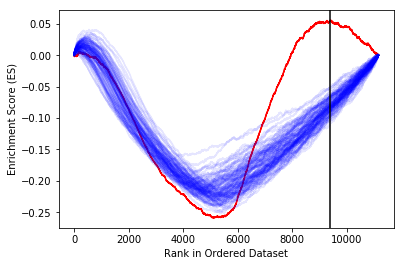

In [20]:
plt.plot(np.arange(len(ES)),ES,'r-')
for i in range(100):
    plt.plot(np.arange(len(ES)),control2[i],'b-',alpha=0.1)

plt.axvline(x=np.argmax(ES),color='black')
# plt.title("Diseased Cell Set")
plt.xlabel("Rank in Ordered Dataset")
plt.ylabel("Enrichment Score (ES)")
plt.savefig(save_path+'figures/SupFigure8/ES.MSinCSF.Th1.inverse.pdf')

In [21]:
with open(save_path + 'CSEA/Th1.MSinCSF.pkl', 'wb') as f:
    pickle.dump((ES,control2), f)


The history saving thread hit an unexpected error (OperationalError('database is locked')).History will not be written to the database.


### Pvalue

In [22]:
np.mean(np.asarray([np.max(x) for x in control2]) > np.max(ES))

0.0

### Leading Edge

In [23]:
np.argmax(ES)

9412

# in blood

In [36]:
s = iscontrol[isCSF==False]
score = np.asarray(VisionScore['Th1'])[isCSF==False]
ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
ranked = ranked.sample(frac=1)
ranked = ranked.sort_values(by='score',ascending=False)
s = np.asarray(ranked['s'])
score = np.asarray(ranked['score'])

In [37]:
ES = ES_fast(score,s,1,1)

In [38]:
np.max(ES)

0.16175216848613783

In [26]:
from random import sample

In [27]:
control = [ES_fast(score,np.asarray(sample(list(s),len(s))),1,1) for i in range(100)]

In [28]:
control_score = pd.read_csv('../CSF/signatures/sigScore.Th1.matched.csv')
control_score = control_score.loc[isCSF==False]
control_score = control_score[control_score.columns[1:]]

In [29]:
control2 = []
for x in control_score.columns:
    score = control_score[x]
    ranked = pd.DataFrame(np.asarray([s, score]).T,columns=['s','score'])
    ranked = ranked.sample(frac=1)
    ranked = ranked.sort_values(by='score',ascending=False)
    s = np.asarray(ranked['s'])
    score = np.asarray(ranked['score'])
    control2.append(ES_fast(score,s,1,1))

### Pvalue

In [30]:
np.mean(np.asarray([np.max(x) for x in control2]) > np.max(ES))

0.0

### Leading Edge

In [31]:
np.argmax(ES)

10040

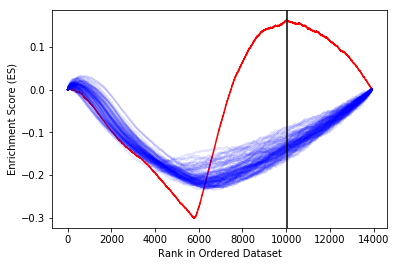

In [32]:
plt.plot(np.arange(len(ES)),ES,'r-')
for i in range(100):
    plt.plot(np.arange(len(ES)),control2[i],'b-',alpha=0.1)

plt.axvline(x=np.argmax(ES),color='black')
# plt.title("Diseased Cell Set")
plt.xlabel("Rank in Ordered Dataset")
plt.ylabel("Enrichment Score (ES)")
plt.savefig(save_path+'figures/SupFigure8/ES.MSinPBMC.Th1.inverse.pdf')

# Significance value 
0.013 in blood
0.0 in CSF